# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

> Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

This is no doubt a classification problem. We need to predict **discrete classes** (to be more specific, this is a binary classification problem): whether a student passes the exam or not. If we had a regression problem, we'd rather work on continuous output or a specific value our function would have. In contrast, currently we are not interested in the function value.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


> Now, can you find out the following facts about the dataset?
> - Total number of students
> - Number of students who passed
> - Number of students who failed
> - Graduation rate of the class (%)
> - Number of features

> _Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
n_students = len(student_data)
n_features = len(student_data.columns[:-1])
n_passed = len(student_data.groupby('passed').groups['yes'])
n_failed = len(student_data.groupby('passed').groups['no'])
grad_rate = n_passed / float(n_students) * 100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


Total number of students: **395**

Number of students who passed: **265**

Number of students who failed: **130**

Number of features: **30** — 30 features and a vector of labels (exam results)

Graduation rate of the class: **67.09%** (accuracy less than 0.67 may be considered worthless).

## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

> As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

> Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

> These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
y_all = y_all.replace(['yes', 'no'], [1, 0])
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [6]:
print "{} cols; {} rows.".format(len(X_all.columns), len(X_all))

48 cols; 395 rows.


In [7]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=999)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
> Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

> - What are the general applications of this model? What are its strengths and weaknesses?
> - Given what you know about the data so far, why did you choose this model to apply?
> - Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

> Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

> Note: You need to produce 3 such tables - one for each model.

### The importance of assumptions about our data
Before any training, let's explore our dataset and try to observe issues that might assist us to decide which model is applicable and how we should approach our optimization problem in general.

We take a quick glance at the features in our initial dataset (before adding dummy columns):

In [8]:
student_data.columns[:-1]

Index([u'school', u'sex', u'age', u'address', u'famsize', u'Pstatus', u'Medu',
       u'Fedu', u'Mjob', u'Fjob', u'reason', u'guardian', u'traveltime',
       u'studytime', u'failures', u'schoolsup', u'famsup', u'paid',
       u'activities', u'nursery', u'higher', u'internet', u'romantic',
       u'famrel', u'freetime', u'goout', u'Dalc', u'Walc', u'health',
       u'absences'],
      dtype='object')

First observations:

1. There is a good amount of features, but a very limited number of training examples. The latter is problematic because our model might, and probably will, get underfit. Thus we need to choose three models that can work well for such a dataset.

2. Slightly unbalanced target feature. We have 130 zeros and 265 ones, but, actually, the difference is not significant.

3. Most of features are not logically related to the score of a student (e.g 'address', 'Mjob', 'Fjob' and many others). Although it's handy to have them (they may influence the exam score for a student altogether), they may contribute to the noise and false patterns our model can grasp. I'd recommend carefully engineer our features first using a recursive feature elimination (RFE) or univariate feature selection.

Although, I'll stick with the whole set of features in this assignment.

### PCA for data exploration and patterns visualization

Since it's impossible to visualize our data due to a large number of features (many of which are binary), let's use PCA to reduce dimensionality. We won't use this modified dataset for training. The main goal is to understand and visualize our features and spot patterns.

PCA, or principal component analysis, is a procedure that uses an orthogonal transformation to convert samples with correlated features into another set of variables of *uncorrelated* features called principal components. This way, the first principal component covers the largest possible variance. Other components cover the rest of the variance under constraint that *they must be orthogonal to the previous one*.

I need to notice that it's quite tricky to interpret the results of PCA. But if we have a dominating component and the rest cover just a small percentage of the variance, we can drop them from our feature list as they contribute to noise and just increase the dimensionality of our data.

In [9]:
pca = PCA(n_components=5) # Five is enough
pca.fit(X_all, y_all)
X_transformed = pca.transform(X_all)
X_train_, X_test_, y_train, y_test = train_test_split(X_transformed, y_all, test_size=num_test, random_state=999) # PCA
pca.explained_variance_ratio_

array([ 0.77491455,  0.03418989,  0.02801583,  0.02369683,  0.01698655])

As we see, the first component contribues to 77.5% of the overall variance. It clearly dominates among other components (the next one only covers 3.4% of the variance).

This confirms our previous idea of having too many low-profile features. Due to this observation, we should choose the model that can be tolerant to the high-dimensional, noisy data.

After data transformation, we may finally have a chance to visualize our dataset (component1, component2) and color mark exam results:

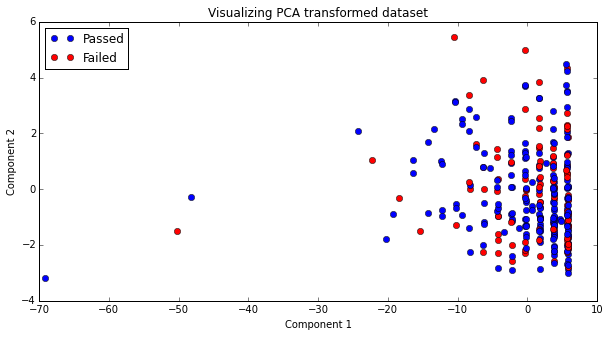

In [10]:
plt.figure(figsize=(10,5))
for c1,c2,y0 in zip(list(X_transformed[:,0]), list(X_transformed[:,1]), list(y_train.replace([1, 0], ['b', 'r']))):
    plt.plot(c1, c2, 'o{}'.format(y0)) # this is quite messy
plt.title('Visualizing PCA transformed dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(['Passed','Failed'], loc=2)
plt.show()

As we see, it's **still challenging to spot data patterns** (even though these two component capture 81% of the variance). This visualization shows **we won't get a high score for our models**. At this point I'd rather reconsidered our features than moved forward. But our task was to find the best model, so I continued :)

Such a noisy dataset encourages overfitting which means that overfitting-prone models (e.g. trees) should be excluded first. We need to keep it in mind.

### More observations about our dataset

**Observation 1.** Data is noisy, patterns are not easy to visualize and we have redundant features.

**Observation 2.** The dataset contains just 395 samples (actually, 300, because 95 are for testing). We also have 48 dimensions. We have a small amount of data points and I'm not sure complex models can work well. Specifically, decision trees and random forests.

**Observation 3.** Graduation rate of the class: 67.09% — this means that any score (accuracy) of our classifier below this would be worse than saying every person passed the class.

**Observation 4.** We have a slightly unbalanced target feature: more than 2/3 of the labels are positive and only 1/3 are negative. This imbalance is a acceptable and it won't skew our results.

**Observation 5.** If we want to boost our pass score to 95%, we need to be able to predict negatives (possible exam failures) very well. We may accept higher levels of false negatives, but we should maximize our accuracy for true negatives. I'd say, **our goal is to maximize specificity.** In this case, F1 score might not be the best measure of performance.

In [11]:
def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

In [12]:
# Predict on training set and compute F1 score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label=1) ### need to change to 'yes'

# train_f1_score = predict_labels(clf, X_train, y_train)
# print "F1 score for training set: {}".format(train_f1_score)

In [13]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

### Relevant models for our project

Let's briefly recap, what we need from our model:

1. To be as simple as possible -- as we are limited in computation resources, our model should be easy to train.

2. To fit our data well (this is a tradeoff between the model quality and the costs).

3. To be tolerant to low amount of samples, noisy data and many irrelevant features. Our model should provide a good score as soon as possible (on a training set of a minumum size).

4. To be easy to explain to the board of supervisors.

I chose three models for my research:

1. **SVC**, though this is a sophisticated model, it can be simplified with the linear kernel. I thought it could provide a good base measure of f1 score and decided to put this model in the first place. With this model, I decided to run a grid search right away to get the best possible score and compare it with two other models.

2. **Logistic regression**, because this model is generic, simple (which means fast and cheap) and easy to explain. LR is naturally suited to our binary classification problem as well.

3. Bayesian model (**Naive Bayes**), due to its simple assumptions and a very good training speed.

### SVM Classifier
A very versatile and commonly used ML algorithm. The basic idea behind SVC is to transform the dataset in such a way that two classes (labels) could be separated by a hyperplane while maximizing the size of the margin between these classes. In our examples I'll use a soft-margin SVM (I consider it naive to assume our data linearly separable).

SVMs can be used for both classification (e.g digits recognition) and regression (e.g predict Boston house prices).
One of the main **advantages** of SVMs is that it's *very versatile*: we can implement our domain knowledge into the model by choosing or constructing a specific kernel.

For example, one of the requirements for our model is to use the least amount of resources (computation time, memory footprint), and SVM with linear kernel can work quite well for this situation.

Another advantage of SVMs is its *tolerance to the low amount of samples* and *efficiency in high dimensional space* (although it's still not advised to have more features than samples). We have just 300 samples and 48 features (the samples/features ratio is quite low).

The **disadvantages** include *a poor performance if the number of samples is much higher* than the number of dimensions or *high computation costs for probability estimates* (sklearn has a way to hide this complexity for us, but it dramatically increases the computation time) . None is applicable to our project (we still have more samples than dimensions and we're not required to provide probability estimates). Anyway, we should keep this in mind, especially if we decide to compare our models using `roc_auc` score.

More serious disadvantage of SVM is that **the exact data transformations inside the model are very hard to grasp.** We have to deal with it as a black box which we feed data into and get results from. It's not quite clear how to describe the process of getting the results in layman's terms.

Now let's train our model and find the best hyperparameters (actually, only one -- C). I keep the kernel fixed as we decided to use only linear models. 

Actually, I tried both linear and rbf kernels, and rbf did not provide a significant score increase. The overall time increased by 30% as expected.

In [14]:
clf_svc = SVC(kernel='linear')
parameters = {'C': [0.005,0.008,0.009,0.01,0.02,0.03,0.04,0.05,0.08,0.09,
                    0.1,0.2,0.3,0.4,.5,.6,.7,.8,.9,1.0,1.1,1.2,1.5,2,3,4,5]}
grid_search_clf_svc = GridSearchCV(clf_svc, param_grid=parameters, scoring='f1', cv=3)
grid_search_clf_svc.fit(X_train, y_train)
grid_search_clf_svc.best_estimator_

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

My best results are below:

```SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
```
  
Let's use SVC with linear kernel and regularization parameter C=0.01.

In [15]:
clf_svc = SVC(C=.01, kernel='linear')
train_predict(clf_svc, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf_svc, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf_svc, X_train[:300], y_train[:300], X_test, y_test)

------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.001
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.78431372549
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.815286624204
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.003
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.801302931596
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.812903225806
------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.006
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.816239316239
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.828025477707


The results:

|SVM (rbf, C=1)     |Training set size = 100|Training set size = 200|Training set size = 300|
|-------------------|:----------------------|:----------------------|:----------------------|
|Training time      |0.001                  |0.003                  |0.006                  |
|Prediction time    |0.001                  |0.002                  |0.003                  |
|f1 for training set|0.784                  |0.801                  |0.816                  |
|f1 for testing set |0.815                  |0.813                  |**0.828**              |

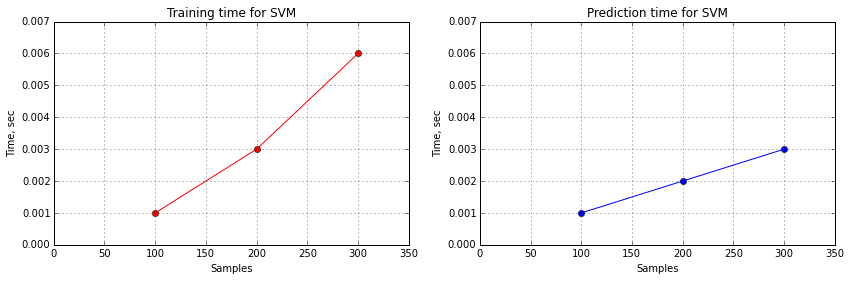

In [27]:
x_samples = [100,200,300]
y_training_time = [.001,.003,.006]
y_prediction_time = [.001,.002,.003]

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(x_samples, y_training_time, 'ro-')
plt.grid(True, linestyle=':')
plt.xlim(0,350)
plt.ylim(0,.007)
plt.title('Training time for SVM')
plt.xlabel('Samples')
plt.ylabel('Time, sec')

plt.subplot(1,2,2)
plt.plot(x_samples, y_prediction_time, 'bo-')
plt.grid(True, linestyle=':')
plt.xlim(0,350)
plt.ylim(0,.007)
plt.title('Prediction time for SVM')
plt.xlabel('Samples')
plt.ylabel('Time, sec')

plt.show()

Looking at the graphs above, we see a problem: the training and prediction time increases rapidly. The performance is worse than $O(n)$ which might be a serious problem for us and our limited resources.

Another problem is that we have a limited number of observations and cannot be sure about the true performance.

Anyway, we see that the computation time is the weak point of this model, although F1=0.828 is very good.

### Logistic Regression

Logistic (logit) regression is a generalization of linear models used for classification. Logistic regression (and linear models in general) is one of the basic and simplest models to use, yet quite powerful when we consider the tradeoff between model's accuracy and computation costs.

Logistic regression is used in a variety of fields ranging from economics to disease prediction when a researcher is given a number of characteristics of a patient (age, sex, results of blood tests, etc) and is asked to predict whether the patient has a specific disease. This model is **well-suited for a binary classification task** (although it can be extended to multiclass classification via "one-to-many" technique).

Contrasting to many other models (like SVM), the inner workings of logistic regression can be understood and **the process of getting this result can be easily articulated** in simple words.

The probabilities of our possible binary outcomes are modeled with the logistic function which is also **easy to visualize and describe.** Another good point is that it's easy to create a ROC curve using linear regression since we can use `clf.predict_proba()` method to get probabilities of zeros and ones.

Using logistic regression looks like a good choice for our problem: the model is simple, **the cost of computation should be low**. Let's find out whether it's true.

In [17]:
clf_reg = LogisticRegression()

In [28]:
train_predict(clf_reg, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf_reg, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf_reg, X_train[:300], y_train[:300], X_test, y_test)

------------------------------------------
Training set size: 100
Training LogisticRegression...
Done!
Training time (secs): 0.002
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.899224806202
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.739130434783
------------------------------------------
Training set size: 200
Training LogisticRegression...
Done!
Training time (secs): 0.002
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.842105263158
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.731343283582
------------------------------------------
Training set size: 300
Training LogisticRegression...
Done!
Training time (secs): 0.002
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.84259259

Let's create a table:

|Logistic regression|Training set size = 100|Training set size = 200|Training set size = 300|
|-------------------|:----------------------|:----------------------|:----------------------|
|Training time      |0.002                  |0.002                  |0.002                  |
|Prediction time    |0.000                  |0.000                  |0.000                  |
|f1 for training set|0.899                  |0.842                  |0.843                  |
|f1 for testing set |0.739                  |0.731                  |**0.786**              |

And visualize it with a plot:

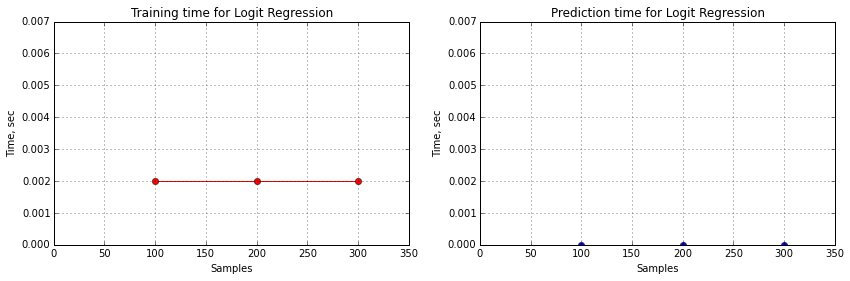

In [29]:
x_samples = [100,200,300]
y_training_time = [.002,.002,.002]
y_prediction_time = [0,0,0]

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(x_samples, y_training_time, 'ro-')
plt.grid(True, linestyle=':')
plt.xlim(0,350)
plt.ylim(0,.007)
plt.title('Training time for Logit Regression')
plt.xlabel('Samples')
plt.ylabel('Time, sec')

plt.subplot(1,2,2)
plt.plot(x_samples, y_prediction_time, 'bo-')
plt.grid(True, linestyle=':')
plt.xlim(0,350)
plt.ylim(0,.007)
plt.title('Prediction time for Logit Regression')
plt.xlabel('Samples')
plt.ylabel('Time, sec')

plt.show()

The final score is 0.786 with constant (sub-linear) training and testing time. This model looks solid and fast.

It's not very representational to talk about Big-O of this algorithm due to a very small amount of observations (only three), but I'd definitely consider this model a clear winner so far.

We should keep in mind that our goal is not to maximize the f1 score by any means, but to find good enough model with a good score and reasonable computation costs.

### Bayesian Learning

Bayesian classifiers are well-known in the world of spam filters, NLP and text classification. As its name says, it is based on Bayes rule. While using a bayesian classifier called Naive Bayes, we have to make a strong opinion that attributes of our model are independent, contrasting to unbiased bayesian learning. Without such an opinion, we'd had to compute a massive amount of parameters: $2 * (2^n - 1)$ (Mitchell, 2015).

Naive Bayes is the approach to bayesian learning in which we do make such an opinion. The Naive Bayes classifier does this by making a conditional independence assumption that dramatically reduces the number of parameters to be estimated from $2*(2^n-1)$ to just $2n$.

This means the main advantage of this model is simplicity and thus it can be trained faster, with less training examples and less computation resources. To sum up:

1. By reducing the complexity of computation, I suppose NB will work well with our limited resources.

2. Naive Bayes requires a small amount of samples (due to its simple model). We don't have much data to learn on, and this should be a good fit.

3. NB learns really fast.

NB is known to be a bad estimator, but we are not supposed to provide estimates (at least, not now, but in the future I'd like to plot the ROC curve and visualize the performance of the model and calculate the AUC score).

Let's implement a simple Naive Bayes classifier. We'll use a standard `GaussianNB` which works well for binary classification tasks like ours.

In [20]:
clf_nb = GaussianNB()
train_predict(clf_nb, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf_nb, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf_nb, X_train[:300], y_train[:300], X_test, y_test)

------------------------------------------
Training set size: 100
Training GaussianNB...
Done!
Training time (secs): 0.001
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.803278688525
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.692307692308
------------------------------------------
Training set size: 200
Training GaussianNB...
Done!
Training time (secs): 0.001
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.809338521401
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.753623188406
------------------------------------------
Training set size: 300
Training GaussianNB...
Done!
Training time (secs): 0.001
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.798004987531
Predicting labels using GaussianNB...
Done!
Prediction time

Our table:

|Naive Bayes        |Training set size = 100|Training set size = 200|Training set size = 300|
|-------------------|:----------------------|:----------------------|:----------------------|
|Training time      |0.001                  |0.001                  |0.001                  |
|Prediction time    |0.000                  |0.000                  |0.000                  |
|f1 for training set|0.803                  |0.809                  |0.798                  |
|f1 for testing set |0.692                  |0.754                  |**0.766**              |

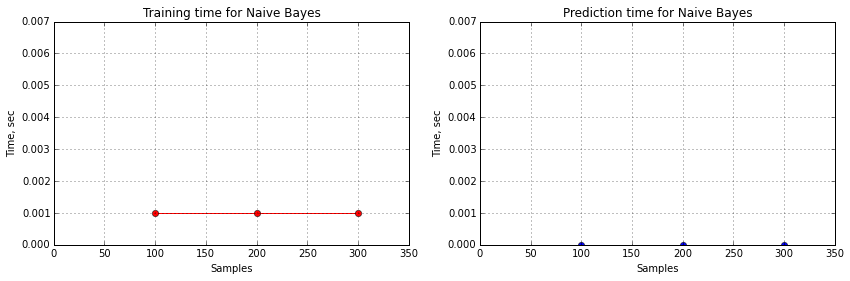

In [30]:
x_samples = [100,200,300]
y_training_time = [.001,.001,.001]
y_prediction_time = [0,0,0]

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(x_samples, y_training_time, 'ro-')
plt.grid(True, linestyle=':')
plt.xlim(0,350)
plt.ylim(0,.007)
plt.title('Training time for Naive Bayes')
plt.xlabel('Samples')
plt.ylabel('Time, sec')

plt.subplot(1,2,2)
plt.plot(x_samples, y_prediction_time, 'bo-')
plt.grid(True, linestyle=':')
plt.xlim(0,350)
plt.ylim(0,.007)
plt.title('Prediction time for Naive Bayes')
plt.xlabel('Samples')
plt.ylabel('Time, sec')

plt.show()

As we expected, the training and prediction times are neglectable, it worked blazingly fast, thus we can really save our resources. On the other hand, the performance of this model is somewhat average, comparing to logistic regression.

## 5. Choosing the Best Model

> - Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
> - In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
> - Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
> - What is the model's final F<sub>1</sub> score?

### Comparing our three models

Now it's time to compare our models and pick the winning one.

Let's summarize three of our target characteristics (f1 score, size of a training set for a reasonable fit, computational resources) in one table. Some remarks:
* f1 score -- F1 score on test set using a trained model (300 samples).

* Min training set -- a minimum training set (100, 200 or 300) needed to achieve F1 >= 0.75

* Computation time -- training + prediction time for 300 training examples.


|Model              |f1 score               |Min training set       |Computation time (300 ex.) |
|-------------------|:----------------------|:----------------------|:--------------------------|
|SVC                |0.828 (best)           |100 (best)             |0.009 (worst)              |
|Logistic Regression|0.786 (good)           |300 (average)          |0.002 (good)               |
|Naive Bayes        |0.766 (average)        |200 (good)             |0.001 (even better)        |
|WINNER             |SVC                    |SVC                    |LR and NB                  |

As we see, the f1 score is a better for SVC, but this classifier is the slowest. It is 4.5 times slower than logistic regression _and_ Naive Bayes as well. Such performance is unacceptable for our limitations.

Also, we should not forget that we used a grid search for SVC so that it's not fair to compare f1 for SVC and for LR.

Currently, I think LR is the best fit for our task. It is 1) simple and noise-tolerant, 2) works well will low amount of samples, 3) it is easy to understand by the board of supervisors. This is a very versatile and generic model with a pretty good performance. It needed more training examples, but it's plausable: we do have this data and the training time for 300 examples was the same as for 100 examples.

Another benefit of LR is that we can easily plot ROC and get its AUC score. It's much harder to do for SVM and NB.

### Explaining logistic regression in laymen terms

Let's imagine that we have two classes (say, 1 and 0) which we need to get predicted.

Logistic regression takes a number of features of a student and returns 1 (passed) or 0 (failed) as a prediction. To get a prediction, we need to train our model on data with labels (1 or 0) we know. 

**Prediction**

To "put" the features into the model, we use an equation in the form $a_1 * x_1 + a_2 * x_2 + ... + a_n * x_n$, where $a_1...a_n$ are coefficients trained by the model beforehand, $x_1...x_n$ are the values of our features. To receive the final hypothesis (output) we also need to modify the result above using a so-called sigmoid function.

**Training**

To train the model on data means to find the $a_1...a_n$ coefficients and use them for prediction. We do so by using a labeled set with known correct output. How do we find these coefficients? Basically, we do this in several steps:
1. Choose a random set of values for coefficients and insert them into our equation as a list of a's
2. Calculate output class for each of our training set.
3. Compare the resulting list of classes with the known correct classes and calculate the score of the model.
4. Modify our coefficients a little bit and run steps 2-3. Compare the new score with the previous one. If the new score is better, modify coefficients further in the same direction. If not, modify them in a different direction. Stop when the difference between two scores gets too small.
5. Use the final coefficients as a's in our model.

### Training the final model

As we discussed, we'd use logistic regression as our final model. Now let's find the best hyperparameters and see whether we can beat SVM score.

In [22]:
clf_reg_final = LogisticRegression()
parameters = {'C': [.001,.002,.003,.004,.005,.006,.007,.008,.009,.1,.2,.5,1,1.1,1.2,1.5,2,3,5], 'penalty': ['l1','l2']}
grid_search_clf_reg = GridSearchCV(clf_reg_final, param_grid=parameters, scoring='f1', cv=3)
grid_search_clf_reg.fit(X_train, y_train)
grid_search_clf_reg.best_estimator_

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We found out this:

```LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
```

The best hyperparameter C is 0.1 with l1 regularization.

In [23]:
clf_reg_final = LogisticRegression(C=0.1, penalty='l1')
train_predict(clf_reg_final, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf_reg_final, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf_reg_final, X_train[:300], y_train[:300], X_test, y_test)

------------------------------------------
Training set size: 100
Training LogisticRegression...
Done!
Training time (secs): 0.001
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.825174825175
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.83660130719
------------------------------------------
Training set size: 200
Training LogisticRegression...
Done!
Training time (secs): 0.001
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.8
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.805369127517
------------------------------------------
Training set size: 300
Training LogisticRegression...
Done!
Training time (secs): 0.004
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.825327510917
Predict

```
Training set size: 300
Training LogisticRegression...
Done!
Training time (secs): 0.003
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.825327510917
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.831168831169
```

Using the entire training set (300 training examples), we get the final score **0.831** which is even better than the linear SVM.

## 5\*. ROC, AUC and the final model score

After the final part of my research and getting the f1 score as required, let me test the real quality of my model.

As I mentioned earlier, I didn't see any strong patterns in data and after visualizing PCA components that point became clear. Now I'd like to **really** test my classifier with AUC score. Of course, we need to plot ROC curve first.

As we know, ROC is represented by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. This curve and the area under the curve (AUC) provide a solid measurement of model quality.

In [24]:
from sklearn import metrics

In [25]:
def plot_roc_curve(title, y_test, predicted, label='?'):
    fpr, tpr, th = metrics.roc_curve(y_test, predicted[:,1])
    plt.figure(figsize=(10,7))
    plt.plot(fpr, tpr, label=label);
    plt.plot([1,0], [1,0], 'r--')
    plt.xlabel('False Positive'); plt.ylabel('True Positive'); plt.title(title)
    plt.legend(bbox_to_anchor=(1, 1), loc=2); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1]);
    plt.show()
    print metrics.auc(fpr, tpr)

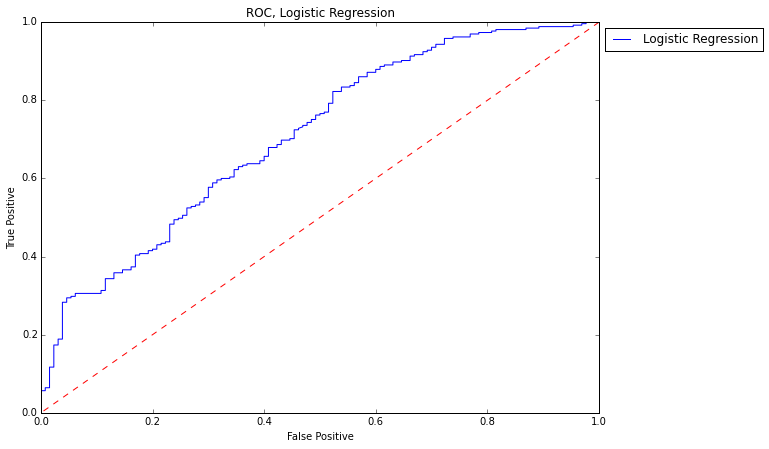

0.708287373004


In [26]:
plot_roc_curve('ROC, Logistic Regression', y_all, clf_reg_final.predict_proba(X_all), label='Logistic Regression')

As we see, the score of our model is fair, but, of course, it is not 0.831 as we had earlier. Anyway, this visualization proves that our model is significant, which is a good result in itself!